In [1]:
import pandas as pd
import numpy as np
rnd = 384

In [2]:
from exp.data import load_image_dataset, load_tabular_dataset

dataset_name = 'MNIST'

X_train, X_test, Y_train, Y_test, train_loader, test_loader = load_image_dataset(dataset_name, './data/')

In [3]:
X_train = X_train[np.logical_or(Y_train==0,Y_train==8)]
X_test = X_test[np.logical_or(Y_test==0,Y_test==8)]
Y_train = Y_train[np.logical_or(Y_train==0, Y_train==8)]
Y_test = Y_test[np.logical_or(Y_test==0, Y_test==8)]

In [4]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z
    
latent_dim = 30
model = LinearModel(X_train.shape[1],latent_dim)

In [5]:
model.load_state_dict(torch.load(f'./models/{dataset_name}_LinearTransparent_latent_{latent_dim}.pt'))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    Z_train = model(torch.tensor(X_train,dtype=torch.float32)).numpy()
    Z_test = model(torch.tensor(X_test,dtype=torch.float32)).numpy()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Z_train, Y_train)
KNN_pred = neigh.predict(Z_train)

In [8]:
neigh.score(Z_test,Y_test)

0.9953940634595702

In [9]:
from scipy.spatial import distance

def find_changes(start_point, end_point=None, z_end=None, max_iter=5, debug=False):
    
    if z_end is None:
        z_end   = model(torch.tensor(end_point,dtype=torch.float32)).detach().numpy()
    z_start = model(torch.tensor(start_point,dtype=torch.float32)).detach().numpy()
    
    w = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    
    mods = np.zeros(len(start_point[0,:]))
    
    x_mod = start_point.copy()+mods
    z_mod = model(torch.tensor(x_mod).float()).detach().reshape(1,-1).numpy()

    pred = int(neigh.predict(z_start))
    pred_mod = int(neigh.predict(z_mod))
    j = 1
    dist = distance.euclidean(z_end,z_mod)
    
    while pred == pred_mod:
        if debug:
            print(distance.euclidean(z_end,z_mod))
        proj = z_end - z_mod
        d = np.argsort(np.abs(proj.dot(w)))
        d_mods = []
        for i in range(-784,0):
            x_mod_prop = x_mod.copy()
            idx = d[0, i]
            mod = np.sum((z_end-(np.sum(x_mod[0,:idx]*w[:,:idx],axis=1)+np.sum(x_mod[0,idx+1:]*w[:,idx+1:],axis=1))-b)*w[:,idx])/(np.sum(w[:,idx]**2))
            mod = np.clip(mod,0,1)
            x_mod_prop[0, idx] = mod
            z_mod_prop = model(torch.tensor(x_mod_prop).float()).detach().reshape(1,-1).numpy()
            d_mods.append(distance.euclidean(z_end,z_mod_prop))
        idx = d[0,range(-784,0)[np.argmin(d_mods)]]
        mod = np.sum((z_end-(np.sum(x_mod[0,:idx]*w[:,:idx],axis=1)+np.sum(x_mod[0,idx+1:]*w[:,idx+1:],axis=1))-b)*w[:,idx])/(np.sum(w[:,idx]**2))
        mod = np.clip(mod,0,1)
        mods[idx] += mod - x_mod[0,idx]
        x_mod[0, idx] = mod
        z_mod = model(torch.tensor(x_mod).float()).detach().reshape(1,-1).numpy()
        
        if distance.euclidean(z_end,z_mod) == dist:
            j +=1
        else:
            j = 1
            dist = distance.euclidean(z_end,z_mod)
        
        if j == max_iter:
            break
        
        pred_mod = int(neigh.predict(z_mod))
        if debug:
            print(pred,pred_mod)
            print(j)
        
    return mods

In [10]:
def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())

idx = 1
q = X_test[idx].reshape(1,-1).copy()
pred = int(predict(q))
pred

0

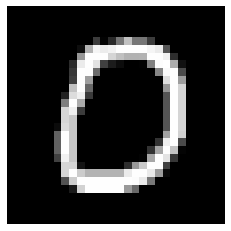

In [11]:
plt.imshow(q.reshape(28,28),cmap='gray')
plt.axis(False);

In [12]:
centroid_0 = np.mean(Z_train[Y_train==0],axis=0)
centroid_8 = np.mean(Z_train[Y_train==8],axis=0)

mods = find_changes(q, z_end=centroid_8, debug=False)

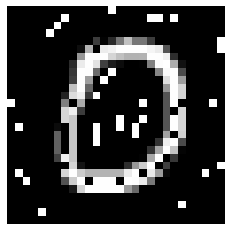

In [13]:
plt.imshow((q+mods).reshape(28,28),cmap='gray')
plt.axis(False);

# Gradient descend Input space

In [16]:
def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())

In [17]:
q = X_test[idx].reshape(1,-1).copy()
pred = int(predict(q))
pred

0

In [18]:
mods = X_test[idx].reshape(1,-1).copy()
mods = torch.nn.parameter.Parameter(torch.tensor(mods, requires_grad=True).float())
loss = torch.nn.MSELoss()

In [19]:
loss(torch.tensor(centroid_8).reshape(1,-1),model(mods))

tensor(2.1183, grad_fn=<MseLossBackward0>)

In [20]:
opt = torch.optim.Adam([mods],lr=0.001)

In [24]:
from tqdm.notebook import tqdm
total_loss = []

while pred == 0:
    loss_epoch = loss(torch.tensor(centroid_8).reshape(1,-1),model(mods)) 
    total_loss.append(loss_epoch.item())
    loss_epoch.backward()
    opt.step()
    opt.zero_grad()
    pred = int(neigh.predict(model(mods).detach().numpy()))

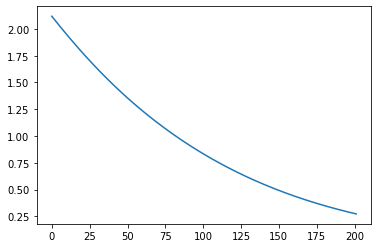

In [25]:
plt.plot(total_loss);

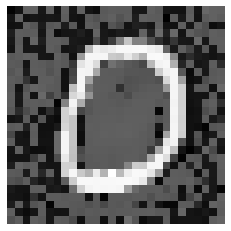

In [26]:
plt.imshow(mods.detach().numpy().reshape(28,28),cmap='gray')
plt.axis(False);

# Growing Spheres

In [52]:
from growingspheres import counterfactuals as cf

def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())
idx = 1
q = X_test[idx].reshape(1,-1).copy()
pred = int(predict(q))
pred

0

In [90]:
CF = cf.CounterfactualExplanation(q, predict, method='GS', target_class=8)
CF.fit(n_in_layer=2000, first_radius=10, dicrease_radius=10, sparse=True, verbose=True)
q_cf = CF.enemy

0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  10
Final radius:  (17.200000000000003, 19.000000000000004)
Final number of ennemies:  1
Feature selection...
Reduced 702 coordinates


In [91]:
predict(q_cf.reshape(1,-1))

array([8])

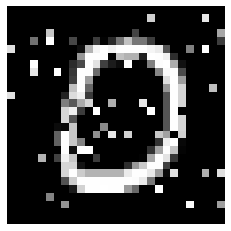

In [93]:
plt.imshow(np.clip(q_cf,0,1).reshape(28,28),cmap='gray')
plt.axis(False);